In [1]:
import numpy as np

import matplotlib.pyplot as plt

from numba import njit, vectorize, float32

from monk import nb

from typing import Callable, Optional

import hoomd
import hoomd.forward_flux.forward_flux as ffs
import gsd.hoomd

from monk import prep
from monk import pair
import ex_render

from monk import nb

In [2]:
cpu = hoomd.device.CPU()
seed = 3412
sim = ffs.ForwardFluxSimulation(cpu, 20, seed=seed)

In [3]:
sim.create_state_from_gsd("equilibrated-0.4-new.gsd")

In [4]:
from hoomd.custom import Action
import freud
import time

class TrackParticle(Action):

    def __init__(self, pid):
        self._pid = pid
        self.data = []

    def act(self, timestep):
        # if isinstance(self._simulation.device, hoomd.device.CPU):
        with self._state.cpu_local_snapshot as data:
            idx = data.particles.rtag[self._pid]
            self.data.append(np.array(data.particles.position[idx], copy=True))

@njit
def _diff_with_rtag(ref_pos, pos, rtags):
    out = np.zeros_like(pos)
    n = len(rtags)
    for tag_idx in range(n):
        idx = rtags[tag_idx]
        out[idx] = pos[idx] - ref_pos[tag_idx]
    return out

class ZeroDrift(Action):

    def __init__(self, reference_positions, box):
        self._ref_pos = reference_positions
        self._box = freud.box.Box.from_box(box)
        # self._imgs = np.array([0.0, 0.0, 0.0])

    @classmethod
    def from_state(cls, state: hoomd.State):
        return cls(state.get_snapshot().particles.position, state.box)

    def act(self, timestep):
        with self._state.cpu_local_snapshot as data:
            pos = data.particles.position._coerce_to_ndarray()
            rtags = data.particles.rtag._coerce_to_ndarray()
            diff = self._box.wrap(_diff_with_rtag(self._ref_pos, pos, rtags))
            # plt.hist(diff)
            # plt.yscale('log')
            # plt.show()
            # time.sleep(1.0)
            dx = np.mean(diff, axis=0)
            data.particles.position = self._box.wrap(data.particles.position - dx)


In [5]:
integrator = hoomd.md.Integrator(dt=0.0025)
tree = hoomd.md.nlist.Tree(0.3)
# lj = pair.KA_LJ_DPD(tree, 0.1)
lj = pair.KA_LJ(tree)
# swap_forces = [lj_swap]

lang = hoomd.md.methods.Langevin(hoomd.filter.All(), 0.4)
# lang = hoomd.md.methods.NVE(hoomd.filter.All())
integrator.forces = [lj]
integrator.methods = [lang]
sim.operations.integrator = integrator

# set zero drift
pos = sim.state.get_snapshot().particles.position
box = sim.state.box
trigger = hoomd.trigger.Periodic(1)
remove_drift = hoomd.update.CustomUpdater(trigger, ZeroDrift(pos, box))
sim.operations.updaters.clear()
sim.operations.updaters.append(remove_drift)

# add writer
# writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(10), filename="another-test4.gsd", mode="wb", filter=hoomd.filter.All())
# sim.operations.writers.clear()
# sim.operations.writers.append(writer)

In [6]:
sim.run(10_000)

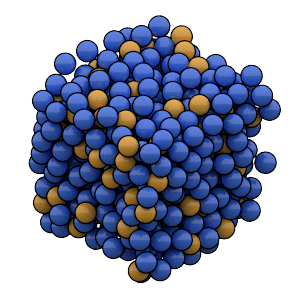

In [10]:
ex_render.render_sphere_frame(frame=sim.state.get_snapshot())

In [7]:
sim.run(100_000)

In [8]:
hoomd.write.GSD.write(sim.state, "equilibrated-0.4-new.gsd")

In [6]:
basin_op = sim.sample_basin(1_000, 1)

In [7]:
sim.basin_barrier = np.quantile(basin_op, 0.999)
sim.basin_barrier

0.2936840136269137

In [15]:
sim.basin_barrier = 0.1

In [7]:
sim.basin_barrier = 0.2936840136269137

Text(0, 0.5, '$P(\\Delta r)$')

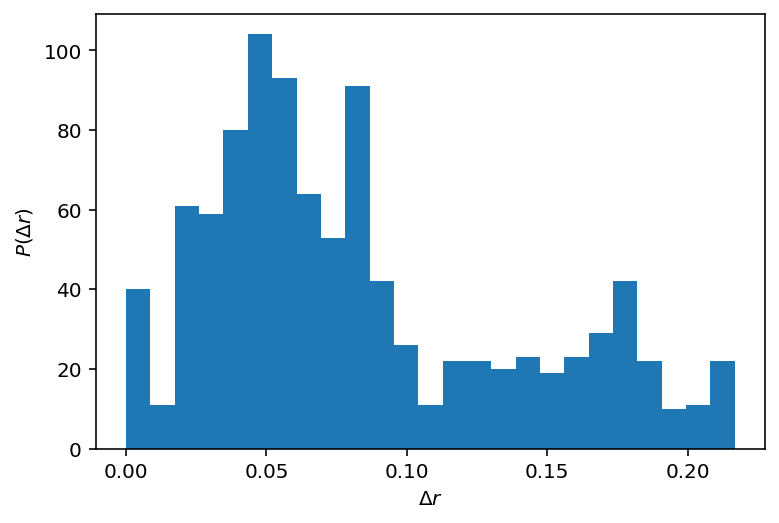

In [8]:
plt.hist(basin_op, bins=25)
plt.xlabel(r"$\Delta r$")
plt.ylabel(r"$P(\Delta r)$")

Text(0.5, 0, '$t$')

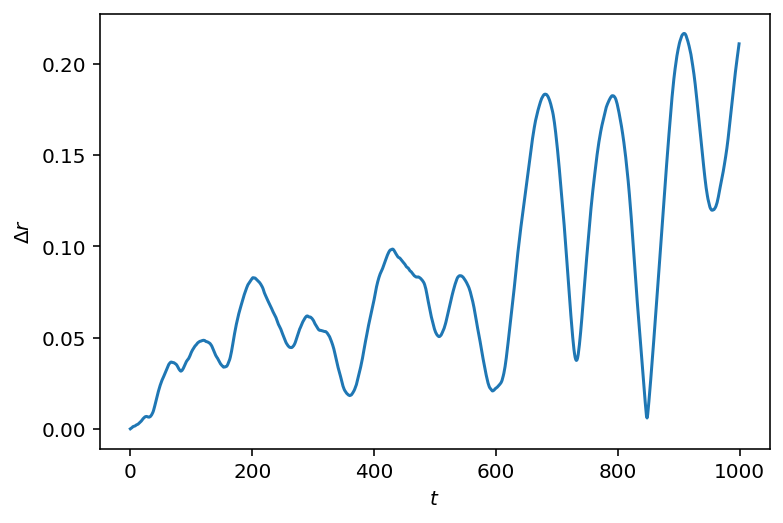

In [9]:
plt.plot(basin_op)
plt.ylabel(r"$\Delta r$")
plt.xlabel(r"$t$")

In [32]:
sim.operations.updaters.clear()

In [19]:
sim.seed = 100

In [32]:
sim.timestep

2240614

In [9]:
sim.seed

3412

In [46]:
trigger = hoomd.trigger.Periodic(1)
tracker = hoomd.write.CustomWriter(trigger, TrackParticle(20))
sim.operations.writers.append(tracker)

In [ ]:
tracker.action.data.clear

In [51]:
len(tracker.action.data)

30

In [15]:
tracker.action.data[10:]

NameError: name 'tracker' is not defined

In [ ]:
sim.operations.updaters.clear()

In [11]:
sim.reset_state()
rate, data = sim.run_ff(10_000, trials=100, barrier_step=0.01, flex_step=True, op_thresh=sim.basin_barrier+0.1, thresh=0.9)

Crossing: 1
state: 0
barrier: 0 0.3036840136269137 (1.0)
barrier: 1 0.3136840136269137 (0.03)
barrier: 2 0.31398401362691375 (1.0)
barrier: 3 0.32398401362691376 (0.0)
final rate: 0.0


In [17]:
rate

0.004

In [17]:
sim.basin_barrier

0.2717029657705018

In [14]:
sim.basin_barrier

0.14949862787000084

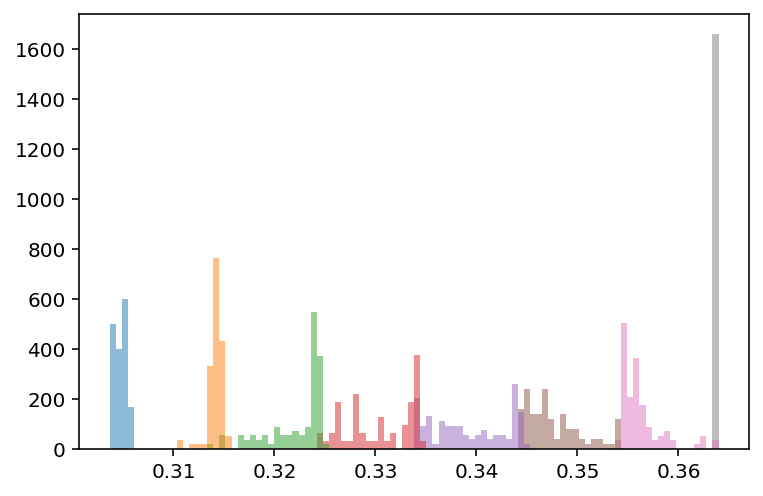

In [27]:
plt.hist(data[0], histtype="stepfilled", density=True, alpha=0.5, bins=100);
plt.ylabel

In [11]:
writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(10), filename="another-test2.gsd", mode="xb", filter=hoomd.filter.All())
sim.operations.writers.clear()
sim.operations.writers.append(writer)
sim.run(100_000)